<font size="6">**Kaggle Test Using TensorFlow**</font>

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt

import os
import math as math
# import sys
# import tarfile
# from IPython.display import display, Image
# from scipy import ndimage
# from sklearn.linear_model import LogisticRegression
# from six.moves.urllib.request import urlretrieve
# from six.moves import cPickle as pickle

import numpy as np # linear algebra
import tensorflow as tf

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

print("TensorFlow Version:",tf.__version__)
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

TensorFlow Version: 1.13.1


In [3]:
path = os.listdir("../../data/digit-recognizer")
print(path)

['test.csv', 'train.csv']


In [4]:
# Read the data
train_data = pd.read_csv('../../data/digit-recognizer/train.csv')
test_data = pd.read_csv("../../data/digit-recognizer/test.csv")

In [5]:
# Set up the data
y_train = train_data['label'].values
X_train = train_data.drop(columns=['label']).values/255

# Test Data
X_test_public = test_data.values/255

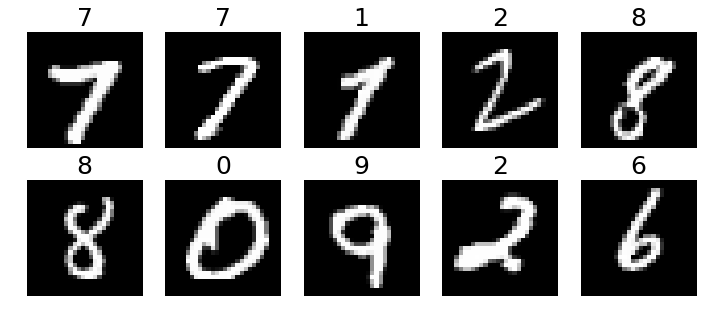

In [6]:
def save_submission(name, dataset, pred_labels):
    # Generating submission using pandas for grading
    submission = pd.DataFrame({'ImageId': range(1, len(dataset) + 1), 'Label': pred_labels })
    submission.to_csv(name, index = False)

def displayImages(data, label):
    fig, axes = plt.subplots(2,5, figsize=(12,5))
    axes = axes.flatten()

    xsize = data.shape[0]
    # Get random Variables
    idx = np.random.randint(0, xsize, size=10)
    for i in range(10):
        axes[i].imshow(data[idx[i],:].reshape(28,28), cmap='gray')
        axes[i].axis('off') # hide the axes ticks
        axes[i].set_title(str(int(label[idx[i]])), color= 'black', fontsize=25)
    plt.show()


displayImages(X_train, y_train)

Training: (41580, 784) (41580,)
Validation: (210, 784) (210,)
Testing: (210, 784) (210,)


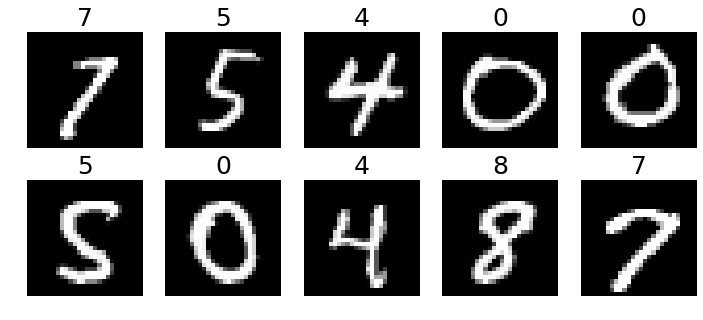

Training set (41580, 784) (41580, 10)
Validation set (210, 784) (210, 10)
Test set (210, 784) (210, 10)


In [75]:
train = 0.99
train_size = int(X_train.shape[0]*train)
valid_size = int(X_train.shape[0]*(1.0 - train)/2.0)
test_size = int(X_train.shape[0]*(1.0 - train)/2.0)

# print("train_size: %0.d"%train_size)
# print("valid_size: %0.d"%valid_size)
# print("test_size: %0.d"%test_size)

def shuffle_data(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
# Mix all the data
shuffle_data(X_train, y_train)

# Get Train Data
start_t = 0
end_t = train_size
train_dataset = X_train[start_t:end_t,:]
train_labels = y_train[start_t:end_t]

# Get Validation Data
start_t = train_size
end_t = valid_size + train_size
valid_dataset = X_train[start_t:end_t,:]
valid_labels = y_train[start_t:end_t]

# Get Test Data
start_t = valid_size + train_size
end_t = valid_size + train_size + test_size
test_dataset = X_train[start_t:end_t,:]
test_labels = y_train[start_t:end_t]

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

# Check if they are still ok
displayImages(train_dataset, train_labels)

image_size = 28  # Pixel width and height.
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

<font size="4">**TensorFlow**</font>

In [7]:
def accuracy(predictions, labels):
    correct_prediction = np.argmax(predictions, 1) == np.argmax(labels, 1)
    accuracy = (100.0 * np.sum(correct_prediction) / predictions.shape[0])
    return accuracy

Logistic Regression

In [ ]:
# Create graph object: instantiate
graph = tf.Graph()
with graph.as_default():
    '''INPUT DATA'''
    tf_train_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels], name = 'y-input')
    tf_valid_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    #y_valid = tf.placeholder(tf.float32, shape = [None, num_labels], name = 'y-input')
    tf_test_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    #y_test = tf.placeholder(tf.float32, shape = [None, num_labels], name = 'y-input')
    
    # Variables    
    # They are variables we want to update and optimize.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases 
    # Original loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,  logits=logits) )
    
    '''OPTIMIZER'''
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    '''PREDICTIONS'''
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [ ]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.

# train_subset = 2000
train_subset = train_dataset.shape[0];
valid_subset = valid_dataset.shape[0]
test_subset = test_dataset.shape[0]

num_steps = 10000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = 0
        batch_data = train_dataset[offset:train_subset,:]
        batch_labels = train_labels[offset:train_subset, :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        l, predictions, _ = session.run([loss, train_prediction, optimizer], feed_dict = feed_dict)
                
        if (step % 500 == 0):
            print('============================================')
            print("Loss at step {}: {}".format(step, l))
            print("Training accuracy: {:.1f}%".format(accuracy(predictions, train_labels[:train_subset, :])))
            print("Validation accuracy: {:.1f}%".format(accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels)))
    print('=================Finished!!=====================')
    print("Test accuracy: {:.1f}%".format(accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels)))

Logistic Regrresion with Sthocastic Gradiend Descent

In [ ]:
graph = tf.Graph()
with graph.as_default():
    '''INPUT DATA'''
    tf_train_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels], name = 'y-input')
    tf_valid_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_test_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    
    # Variables    
    # They are variables we want to update and optimize.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases 
    # Original loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,  logits=logits) )
    
    '''OPTIMIZER'''
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    '''PREDICTIONS'''
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [ ]:
batch_size = 128
num_steps = 10001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        l, predictions, _ = session.run([loss, train_prediction, optimizer], feed_dict = feed_dict)
                
        if (step % 5000 == 0):
            print('============================================')
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}%".format(accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels)))
    print('=================Finished!!=====================')
    print("Test accuracy: {:.1f}%".format(accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels)))

Logistic Regression with Sthocastic Gradiend Descent and 1-hide layer

In [ ]:
graph = tf.Graph()
with graph.as_default():
    '''INPUT DATA'''
    tf_train_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels], name = 'y-input')
    tf_valid_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_test_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    
    # Variables    
    # They are variables we want to update and optimize.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1 
    
    #Activation function
    relu_layer = tf.nn.relu(logits_1, name = 'activation')
    tf.summary.histogram('Activations', relu_layer)
    
    # Training computation.
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2    
    
    # Original loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,  logits=logits_2) )
    
    '''OPTIMIZER'''
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    '''PREDICTIONS'''
    train_prediction = tf.nn.softmax(logits_2)
    
    '''Validation'''
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer = tf.nn.relu(logits_1, name = 'activation')
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    valid_prediction = tf.nn.softmax(logits_2)

    '''Test'''
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1, name = 'activation')
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    test_prediction = tf.nn.softmax(logits_2)    

In [ ]:
num_nodes = 1024
batch_size = 128

num_steps = 10001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        l, predictions, _ = session.run([loss, train_prediction, optimizer], feed_dict = feed_dict)
                
        if (step % 5000 == 0):
            print('============================================')
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}%".format(accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels)))
    print('=================Finished!!=====================')
    print("Test accuracy: {:.1f}%".format(accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels)))

Using Regularization

In [ ]:
# This is a good beta value to start with
beta = 0.01

graph = tf.Graph()
with graph.as_default():
    '''INPUT DATA'''
    tf_train_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels], name = 'y-input')
    tf_valid_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_test_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    
    # Variables    
    # They are variables we want to update and optimize.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases 
    # Original loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,  logits=logits) )

    # Loss function using L2 Regularization
    regularizer = tf.nn.l2_loss(weights)
    loss = tf.reduce_mean(loss + beta * regularizer)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax( tf.matmul(tf_valid_dataset, weights) + biases )
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [ ]:
# This is to expedite the process 
train_subset = 10000
#train_subset = train_dataset.shape[0]
valid_subset = valid_dataset.shape[0]
test_subset = test_dataset.shape[0]

num_steps = 5001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        train_data = train_dataset[:train_subset, :]
        train_labels = train_labels[:train_subset]
        feed_dict = {tf_train_dataset: train_data, tf_train_labels: train_labels}

        l, predictions, _ = session.run([loss, train_prediction, optimizer], feed_dict = feed_dict)
                
        if (step % 5000 == 0):
            print('============================================')
            print("Loss at step {}: {}".format(step, l))
            print("Training accuracy: {:.1f}%".format(accuracy(predictions, train_labels[:train_subset, :])))
            print("Validation accuracy: {:.1f}%".format(accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels)))
    print('=================Finished!!=====================')
    print("Test accuracy: {:.1f}%".format(accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels)))

#### Neural Network with L2 Regularization

-  Hidden Layer using RELUs    

In [14]:
# This is a good beta value to start with
num_nodes= 1024
beta = 0.01

graph = tf.Graph()
with graph.as_default():
    '''INPUT DATA'''
    tf_train_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels], name = 'y-input')
    tf_valid_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_test_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    
    # Variables    
    # They are variables we want to update and optimize.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1 
    
    #Activation function
    relu_layer = tf.nn.relu(logits_1, name = 'activation')
    
    # Training computation.
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2    
    
    # Original loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,  logits=logits_2))
    
    # Loss function using L2 Regularization
    regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)
    loss = tf.reduce_mean(loss + beta * regularizers)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    '''PREDICTIONS'''
    train_prediction = tf.nn.softmax(logits_2)
    
    '''Validation'''
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer = tf.nn.relu(logits_1, name = 'activation')
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    valid_prediction = tf.nn.softmax(logits_2)

    '''Test'''
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1, name = 'activation')
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    test_prediction = tf.nn.softmax(logits_2)  

In [15]:
batch_size = 128

num_steps = 10001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        l, predictions, _ = session.run([loss, train_prediction, optimizer], feed_dict = feed_dict)
                
        if (step % 5000 == 0):
            print('============================================')
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}%".format(accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels)))
    print('=================Finished!!=====================')
    print("Test accuracy: {:.1f}%".format(accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels)))

Initialized
Minibatch loss at step 0: 3343.325927734375
Minibatch accuracy: 5.5%
Validation accuracy: 23.0%
Minibatch loss at step 5000: 0.45578473806381226
Minibatch accuracy: 96.9%
Validation accuracy: 93.7%
Minibatch loss at step 10000: 0.5341718196868896
Minibatch accuracy: 91.4%
Validation accuracy: 93.1%
=================Finished!!=====================
Test accuracy: 91.4%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---
#### Continuing from the Neural Network with L2 Regularization above

In [17]:
num_steps = 3001

train_dataset_2 = train_dataset[:500, :]
train_labels_2 = train_labels[:500]

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_2.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_2[offset:(offset + batch_size), :]
        batch_labels = train_labels_2[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('============================================')
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}%".format(accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels)))
    print('=================Finished!!=====================')
    print("Test accuracy: {:.1f}%".format(accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels)))

Initialized
Minibatch loss at step 0: 3434.2236328125
Minibatch accuracy: 4.7%
Validation accuracy: 10.8%
Minibatch loss at step 500: 21.735700607299805
Minibatch accuracy: 100.0%
Validation accuracy: 88.0%
Minibatch loss at step 1000: 0.4596632719039917
Minibatch accuracy: 100.0%
Validation accuracy: 87.7%
Minibatch loss at step 1500: 0.300018846988678
Minibatch accuracy: 100.0%
Validation accuracy: 87.8%
Minibatch loss at step 2000: 0.29781514406204224
Minibatch accuracy: 100.0%
Validation accuracy: 87.4%
Minibatch loss at step 2500: 0.2949833571910858
Minibatch accuracy: 100.0%
Validation accuracy: 87.8%
Minibatch loss at step 3000: 0.2930670976638794
Minibatch accuracy: 100.0%
Validation accuracy: 87.4%
=================Finished!!=====================
Test accuracy: 86.8%


---
Drop Out
---------

In [20]:
num_nodes= 1024
beta = 0.01

graph = tf.Graph()
with graph.as_default():
    '''INPUT DATA'''
    tf_train_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels], name = 'y-input')
    tf_valid_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_test_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    # Dropout on hidden layer: RELU layer
    keep_prob = tf.placeholder("float")
    relu_layer_dropout = tf.nn.dropout(relu_layer, rate = 1.0 - keep_prob)
    
    logits_2 = tf.matmul(relu_layer_dropout, weights_2) + biases_2
    # Normal loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = tf_train_labels , logits = logits_2))
    # Loss function with L2 Regularization with beta=0.01
    regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)
    loss = tf.reduce_mean(loss + beta * regularizers)

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation 
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    test_prediction =  tf.nn.softmax(logits_2)

In [27]:
num_steps = 3001
batch_size = 128

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, keep_prob : 0.5}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0):
            print('============================================')
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}%".format(accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels)))
    print('=================Finished!!=====================')
    print("Test accuracy: {:.1f}%".format(accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels)))

Initialized
Minibatch loss at step 0: 3498.41455078125
Minibatch accuracy: 8.6%
Validation accuracy: 9.8%
Minibatch loss at step 500: 21.46979331970215
Minibatch accuracy: 93.8%
Validation accuracy: 94.6%
Minibatch loss at step 1000: 0.8291898965835571
Minibatch accuracy: 90.6%
Validation accuracy: 93.0%
Minibatch loss at step 1500: 0.5511454939842224
Minibatch accuracy: 93.8%
Validation accuracy: 92.8%
Minibatch loss at step 2000: 0.541413426399231
Minibatch accuracy: 93.0%
Validation accuracy: 93.6%
Minibatch loss at step 2500: 0.6179152727127075
Minibatch accuracy: 91.4%
Validation accuracy: 94.0%
Minibatch loss at step 3000: 0.6477959156036377
Minibatch accuracy: 90.6%
Validation accuracy: 91.6%
=================Finished!!=====================
Test accuracy: 90.8%




---
Multiple layers.
---------

#### Model

- 5 hidden layers NN
  -  RELUs
  -  Number of nodes decrease by 50% with each hidden layer that is deeper in the neural net
-  Overfitting measures
  -  L2 Regularization
    -  Learning rate (beta) with exponential decay
  -  Dropout

-  10,000 steps


In [31]:
batch_size = 128
beta = 0.001

hidden_nodes_1 = 1024
hidden_nodes_2 = int(hidden_nodes_1 * 0.5)
hidden_nodes_3 = int(hidden_nodes_1 * np.power(0.5, 2))
hidden_nodes_4 = int(hidden_nodes_1 * np.power(0.5, 3))
hidden_nodes_5 = int(hidden_nodes_1 * np.power(0.5, 4))


graph = tf.Graph()
with graph.as_default():
    
    '''INPUT DATA'''
    tf_train_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels], name = 'y-input')
    tf_valid_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_test_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    
    '''Variables'''
    # Hidden RELU layer 1
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes_1], stddev=math.sqrt(2.0/(image_size*image_size))))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes_1]))

    # Hidden RELU layer 2
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes_1, hidden_nodes_2], stddev=math.sqrt(2.0/hidden_nodes_1)))
    biases_2 = tf.Variable(tf.zeros([hidden_nodes_2]))
    
    # Hidden RELU layer 3
    weights_3 = tf.Variable(tf.truncated_normal([hidden_nodes_2, hidden_nodes_3], stddev=math.sqrt(2.0/hidden_nodes_2)))
    biases_3 = tf.Variable(tf.zeros([hidden_nodes_3]))
    
    # Hidden RELU layer 4
    weights_4 = tf.Variable(tf.truncated_normal([hidden_nodes_3, hidden_nodes_4], stddev=math.sqrt(2.0/hidden_nodes_3)))
    biases_4 = tf.Variable(tf.zeros([hidden_nodes_4]))
    
    # Hidden RELU layer 5
    weights_5 = tf.Variable(tf.truncated_normal([hidden_nodes_4, hidden_nodes_5], stddev=math.sqrt(2.0/hidden_nodes_4)))
    biases_5 = tf.Variable(tf.zeros([hidden_nodes_5]))
    
    # Output layer
    weights_6 = tf.Variable(tf.truncated_normal([hidden_nodes_5, num_labels], stddev=math.sqrt(2.0/hidden_nodes_5)))
    biases_6 = tf.Variable(tf.zeros([num_labels]))
    
    '''Training computation'''
    # Hidden RELU layer 1
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    hidden_layer_1 = tf.nn.relu(logits_1)
    # Dropout on hidden layer: RELU layer
    keep_prob = tf.placeholder("float")
    hidden_layer_1_dropout = tf.nn.dropout(hidden_layer_1, keep_prob)
    
    # Hidden RELU layer 2
    logits_2 = tf.matmul(hidden_layer_1_dropout, weights_2) + biases_2
    hidden_layer_2 = tf.nn.relu(logits_2)
    # Dropout on hidden layer: RELU layer
    hidden_layer_2_dropout = tf.nn.dropout(hidden_layer_2, keep_prob)
    
    # Hidden RELU layer 3
    logits_3 = tf.matmul(hidden_layer_2_dropout, weights_3) + biases_3
    hidden_layer_3 = tf.nn.relu(logits_3)
    # Dropout on hidden layer: RELU layer
    hidden_layer_3_dropout = tf.nn.dropout(hidden_layer_3, keep_prob)
    
    # Hidden RELU layer 4
    logits_4 = tf.matmul(hidden_layer_3_dropout, weights_4) + biases_4
    hidden_layer_4 = tf.nn.relu(logits_4)
    # Dropout on hidden layer: RELU layer

    hidden_layer_4_dropout = tf.nn.dropout(hidden_layer_4, keep_prob)
    
    # Hidden RELU layer 5
    logits_5 = tf.matmul(hidden_layer_4_dropout, weights_5) + biases_5
    hidden_layer_5 = tf.nn.relu(logits_5)
    # Dropout on hidden layer: RELU layer
    hidden_layer_5_dropout = tf.nn.dropout(hidden_layer_5, keep_prob)
    
    # Output layer
    logits_6 = tf.matmul(hidden_layer_5_dropout, weights_6) + biases_6 
    
    # Normal loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = tf_train_labels, logits = logits_6))
    # Loss function with L2 Regularization with decaying learning rate beta=0.5
    regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + \
                   tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4) + \
                   tf.nn.l2_loss(weights_5) + tf.nn.l2_loss(weights_6)
    loss = tf.reduce_mean(loss + beta * regularizers)
    
    '''Optimizer'''
    # Decaying learning rate
    global_step = tf.Variable(0)  # count the number of steps taken.
    start_learning_rate = 0.5
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_6)
    
    # Predictions for validation 
    valid_logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    valid_relu_1 = tf.nn.relu(valid_logits_1)
    
    valid_logits_2 = tf.matmul(valid_relu_1, weights_2) + biases_2
    valid_relu_2 = tf.nn.relu(valid_logits_2)
    
    valid_logits_3 = tf.matmul(valid_relu_2, weights_3) + biases_3
    valid_relu_3 = tf.nn.relu(valid_logits_3)
    
    valid_logits_4 = tf.matmul(valid_relu_3, weights_4) + biases_4
    valid_relu_4 = tf.nn.relu(valid_logits_4)
    
    valid_logits_5 = tf.matmul(valid_relu_4, weights_5) + biases_5
    valid_relu_5 = tf.nn.relu(valid_logits_5)
    
    valid_logits_6 = tf.matmul(valid_relu_5, weights_6) + biases_6
    
    valid_prediction = tf.nn.softmax(valid_logits_6)
    
    # Predictions for test
    test_logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    test_relu_1 = tf.nn.relu(test_logits_1)
    
    test_logits_2 = tf.matmul(test_relu_1, weights_2) + biases_2
    test_relu_2 = tf.nn.relu(test_logits_2)
    
    test_logits_3 = tf.matmul(test_relu_2, weights_3) + biases_3
    test_relu_3 = tf.nn.relu(test_logits_3)
    
    test_logits_4 = tf.matmul(test_relu_3, weights_4) + biases_4
    test_relu_4 = tf.nn.relu(test_logits_4)
    
    test_logits_5 = tf.matmul(test_relu_4, weights_5) + biases_5
    test_relu_5 = tf.nn.relu(test_logits_5)
    
    test_logits_6 = tf.matmul(test_relu_5, weights_6) + biases_6
    
    test_prediction = tf.nn.softmax(test_logits_6)

Initialized
Minibatch loss at step 0: 4.266349792480469
Minibatch accuracy: 10.2%
Validation accuracy: 16.5%
Minibatch loss at step 500: 1.5100842714309692
Minibatch accuracy: 89.1%
Validation accuracy: 92.8%
Minibatch loss at step 1000: 1.2176426649093628
Minibatch accuracy: 89.1%
Validation accuracy: 94.7%
Minibatch loss at step 1500: 0.8158614039421082
Minibatch accuracy: 94.5%
Validation accuracy: 96.3%
Minibatch loss at step 2000: 0.7730122208595276
Minibatch accuracy: 95.3%
Validation accuracy: 96.5%
Minibatch loss at step 2500: 0.724498450756073
Minibatch accuracy: 93.8%
Validation accuracy: 94.0%
Minibatch loss at step 3000: 0.7107023000717163
Minibatch accuracy: 92.2%
Validation accuracy: 95.3%
Minibatch loss at step 3500: 0.7920072078704834
Minibatch accuracy: 92.2%
Validation accuracy: 96.8%
Minibatch loss at step 4000: 0.44705355167388916
Minibatch accuracy: 98.4%
Validation accuracy: 96.5%
Minibatch loss at step 4500: 0.6300328969955444
Minibatch accuracy: 91.4%
Validation

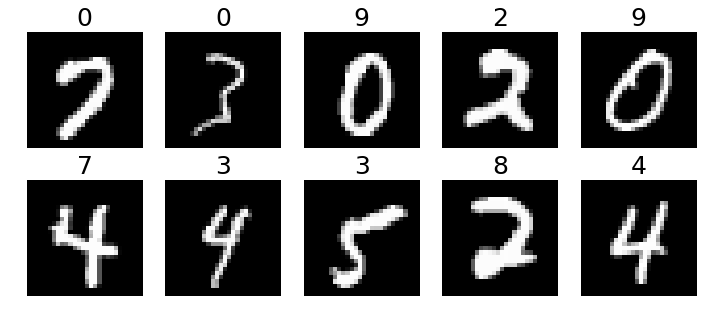

In [68]:
num_steps = 10000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                
        if (step % 500 == 0):
            print('============================================')
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}%".format(accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels)))
    print('=================Finished!!=====================')
    print("Test accuracy: {:.1f}%".format(accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels)))
    
    # Predict test Data
    pred_labels = test_prediction.eval({tf_test_dataset: X_test_public})
    pred_labels = np.argmax(pred_labels, 1)
    displayImages(test_dataset, pred_labels)
    
    # Save in CSV
    save_submission("simplemnist_tf_result.csv", X_test_public, pred_labels)

Test

Initialized
Minibatch loss at step 0: 200.64515686035156
Minibatch accuracy: 9.4%
Validation accuracy: 27.6%
Minibatch loss at step 5000: 0.7543364763259888
Minibatch accuracy: 96.9%
Validation accuracy: 96.7%
Minibatch loss at step 10000: 0.18009300529956818
Minibatch accuracy: 100.0%
Validation accuracy: 97.6%
=================Finished!!=====================
Test accuracy: 97.1%


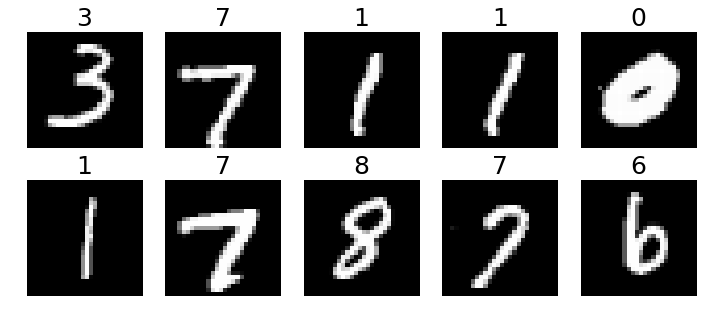

In [79]:
# This is a good beta value to start with
num_nodes = 256 # number of neurons in the hidden layer
beta = 0.001

eta = 5e-1 #Learning Rate
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop

graph = tf.Graph()
with graph.as_default():
    '''INPUT DATA'''
    tf_train_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels], name = 'y-input')
    tf_valid_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    tf_test_dataset = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'x-input')
    
    # Variables    
    # They are variables we want to update and optimize.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_nodes]))
    #biases_1 = tf.Variable(tf.zeros([num_nodes]))
    biases_1 = tf.Variable(tf.constant(1.0, shape=[num_nodes]))
    
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    #biases_2 = tf.Variable(tf.zeros([num_labels]))
    biases_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1 
    
    #Activation function
    relu_layer = tf.nn.relu(logits_1, name = 'activation')
    
    # Training computation.
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2    
    
    # Original loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,  logits=logits_2))
    
    # Loss function using L2 Regularization
    regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)
    loss = tf.reduce_mean(loss + beta * regularizers)
    
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    start_learning_rate = 0.5
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    '''PREDICTIONS'''
    train_prediction = tf.nn.softmax(logits_2)
    
    '''Validation'''
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer = tf.nn.relu(logits_1, name = 'activation')
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    valid_prediction = tf.nn.softmax(logits_2)

    '''Test'''
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1, name = 'activation')
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    test_prediction = tf.nn.softmax(logits_2) 
    
batch_size = 128
num_steps = 10001  # number of iterations of gradient descent

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        l, predictions, _ = session.run([loss, train_prediction, optimizer], feed_dict = feed_dict)
                
        if (step % 5000 == 0):
            print('============================================')
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}%".format(accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels)))
    print('=================Finished!!=====================')
    print("Test accuracy: {:.1f}%".format(accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels)))
    
    # Predict test Data
    pred_labels = test_prediction.eval({tf_test_dataset: X_test_public})
    pred_labels = np.argmax(pred_labels, 1)
    displayImages(X_test_public, pred_labels)
    
    # Save in CSV
    save_submission("simplemnist_tf_result.csv", X_test_public, pred_labels)